In [1]:
import os
import torch
from trainer import eval, train
from transformers import GPT2Config, GPT2Model
from custom_gpt import MyGPT2Attention, SkipBlock, IdentityGPT2Block
from model_load import MyModel
from captum.attr import LayerActivation
from dataset import generate_dataset
from torch.nn import functional as F
from scipy.stats import entropy
import numpy as np
from torch.nn import Identity
from torch import nn
import matplotlib.pyplot as plt

In [2]:
def retrieve_best_model_file(n_layers=1):
    layer_str = str(n_layers)
    models_dir = os.path.join("hard-models/layers/", "layer" + layer_str)
    all_files = [os.path.join(models_dir, f) for f in os.listdir(models_dir)]
    
    best_idx = -1
    best_acc = -1
    for f_idx in range(len(all_files)):
        out = torch.load(all_files[f_idx])

        cur_accuracies = out["accuracies"]
        max_acc = torch.max(torch.tensor(cur_accuracies))
        if max_acc > best_acc:
            best_idx = f_idx
            best_acc = max_acc 
        # if 'train' in out and out['train']:
        #     cur_accuracies = out["accuracies"]
        #     max_acc = torch.max(torch.tensor(cur_accuracies))
        #     if max_acc > best_acc:
        #         best_idx = f_idx
        #         best_acc = max_acc 

    return all_files[best_idx]

In [3]:
def retrieve_model(file_name, device):
    out = torch.load(file_name)
    custom_config = out['custom_config']
    dataset_config = out['dataset_config']
    model_state_dict = out['model_state_dict']
    training_config = out['training_config']
    
    gpt_base = GPT2Model(custom_config).to(device)
    my_model = MyModel(gpt_base, device, custom_config)

    # Swap layers out for getting per-layer activations more easily
    # This fixes bug where we cannot attach captum activation listeners to blocks directly
    my_model.base_model.h = nn.ModuleList([IdentityGPT2Block(custom_config, layer_idx=i) 
                                           for i in range(custom_config.num_hidden_layers)]).to(device)

    # Swap the operations in the attention layer to output attention layer values by head
    for block in my_model.base_model.h:
        block.attn = MyGPT2Attention(my_model.base_model.config, output_per_head=True).to(device)
    
    my_model.load_state_dict(model_state_dict)
    my_model.eval()

    return my_model, custom_config, dataset_config, training_config

In [4]:
n_layers = [1, 2, 4, 8, 16, 24]

best_files = []
for n_l in n_layers:
    best_files.append(retrieve_best_model_file(n_l))

# Evaluate Each Model As a Sanity Check

In [5]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

for f_idx in range(len(n_layers)):
    my_model, custom_config, dataset_config, training_config = retrieve_model(best_files[f_idx], device)
    print(str(n_layers[f_idx]) + " --> ")
    eval(my_model, dataset_config, training_config, device)

1 --> 
45.854166666666664
2 --> 
66.61458333333333
4 --> 
93.33333333333333
8 --> 
98.30208333333333
16 --> 
98.39583333333333
24 --> 
98.19791666666667


# Load Single Layer Model and Capture relevant hidden states

In [10]:
def generate_all_outputs(my_model, dataset_config, training_config, device, batch_sz = 10):
    x, y = generate_dataset(dataset_config, training_config, batch_size_override=batch_sz)
    x = x.to(device)
    y = y.to(device)

    my_model.base_model.output_attentions = False
    hidden_attr = []
    for block in my_model.base_model.h:
        hidden_attr.append(block.attn.c_proj)
    
    for block in my_model.base_model.h:
        hidden_attr.append(block.mlp)
    
    for block in my_model.base_model.h:
        hidden_attr.append(block.ident)

    layer_act = LayerActivation(my_model, hidden_attr)
    all_hidden = layer_act.attribute(x)
    
    my_model.base_model.output_attentions = True
    preds, full_outputs = my_model(x, return_all=True)
    attention = full_outputs[-1]

    return x, y, all_hidden, attention

def process_activations(custom_config, all_hidden):
    n_layers = custom_config.num_hidden_layers

    attn_activations = []
    mlp_activations = []
    residual_activations = []
    
    for idx in range(n_layers):
        attn_activations.append(all_hidden[idx][0].unsqueeze(0))
    for idx in range(n_layers, n_layers*2):
        mlp_activations.append(all_hidden[idx].unsqueeze(0))
    for idx in range(n_layers*2, n_layers*3):
        residual_activations.append(all_hidden[idx].unsqueeze(0))
    
    attn_activations = torch.cat(attn_activations, dim=0)
    mlp_activations = torch.cat(mlp_activations, dim=0)
    residual_activations = torch.cat(residual_activations, dim=0)
    full_attn_activations = torch.sum(attn_activations, dim=2)

    return attn_activations, mlp_activations, residual_activations, full_attn_activations

def process_attention(attention):
    all_attention = torch.cat([a.unsqueeze(1) for a in attention], dim=1)
    mean_attention = torch.mean(all_attention, dim=2)


    per_tok_entropy = entropy(all_attention.cpu().detach().numpy(), axis=4)
    min_attention = np.argmin(per_tok_entropy, axis=2)
    
    min_head_entropy_attention = torch.zeros_like(mean_attention)
    for batch_idx in range(min_attention.shape[0]):
        for layer_idx in range(min_attention.shape[1]):
            for tok_idx in range(min_attention.shape[2]):
                head_idx = min_attention[batch_idx, layer_idx, tok_idx]
                min_head_entropy_attention[batch_idx, layer_idx, tok_idx] = all_attention[batch_idx, layer_idx, head_idx, tok_idx]
    

    return all_attention, mean_attention, min_head_entropy_attention

def predict_outputs(my_model, dataset_config, custom_config, activations, y, 
                    is_hidden_state=True, return_preds=False, return_soft=False, 
                    mask=None, ln_f=False):
    final_indices = dataset_config['span_length']*dataset_config['num_spans']
    decoder_head = my_model.linear.weight.T
        
    selected_activations = activations[:, -final_indices:]
    y = y.reshape(-1)
    

    if is_hidden_state:
        selected_activations = selected_activations.reshape(-1, custom_config.n_embd)
        if mask is not None:
            selected_activations = selected_activations[mask]
            y = y[mask]
        if ln_f:
            selected_activations = my_model.base_model.ln_f(selected_activations)
        pre_soft_vals = torch.matmul(selected_activations, decoder_head)
    else:
        pre_soft_vals = selected_activations.reshape(-1, selected_activations.shape[-1])

    preds = torch.argmax(pre_soft_vals, dim=1)

    if return_preds:
        if return_soft:
            return preds, pre_soft_vals
        else:
            return preds
    else:
        return preds == y


def plot_accuracy_by_pos(dataset_config, reshape_y, correct_arr):
    by_pos_acc_arr = []
    for idx in range(dataset_config['span_length']):
        position_indices = np.arange(len(reshape_y)) % dataset_config['span_length'] == idx
        by_pos_acc_arr.append((sum(correct_arr[position_indices])/sum(position_indices)).cpu().numpy())
    plt.bar(np.arange(len(by_pos_acc_arr)), by_pos_acc_arr)
    plt.xlabel('Span Position')
    plt.ylabel('Accuracy')


def plot_unclean_accuracies(accuracies, title, ax=None, offset=0, sz=.5):
    accuracies = [a.cpu() for a in accuracies]

    if ax is None:
        fig, ax = plt.subplots()
    _ = ax.bar(np.arange(len(accuracies)) - offset, accuracies, sz)
    ax.set_xlabel('Layer')
    ax.set_xticks(np.arange(len(accuracies)))
    ax.set_ylabel('Accuracy')
    ax.set_title(title + " Accuracy")

    return ax

def plot_accuracy_by_layer(activations, my_model, 
                           dataset_config, custom_config, y, 
                           title, ln_f = False,
                           ax=None,offset=0, sz=.5
                          ):
    accuracies = []
    for l_idx, act in enumerate(activations):
        correct_mask = predict_outputs(my_model, dataset_config, custom_config, act, y, ln_f=ln_f)
        accuracies.append(sum(correct_mask)/ y.reshape(-1).shape[0])
    return plot_unclean_accuracies(accuracies, title, ax, offset, sz)


def plot_accuracy_by_layer_head(attn_activations, my_model, dataset_config, custom_config, y, ax=None, ln_f=False):
    if ax is None:
        fig, ax = plt.subplots()

    sz=.1
    
    n_layers = attn_activations.shape[0]
    n_heads = attn_activations.shape[2]

    starting_offset = (sz/2)*(1+n_heads)
    for h_idx in range(n_heads):
        cur_offset = sz*h_idx - starting_offset
        plot_accuracy_by_layer(attn_activations[:, :, h_idx], my_model, 
                               dataset_config, custom_config, y, 
                               "Per-head Attention (L= " + str(custom_config.num_hidden_layers) + ")", 
                               ax=ax, offset=cur_offset, sz=sz, ln_f=ln_f)


def plot_all_accuracies(combined_attn_activations, mlp_activations, residual_activations, attn_activations,
                        my_model, dataset_config, custom_config, y, ln_f = False
                       ):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    
    plot_accuracy_by_layer(combined_attn_activations, my_model, 
                       dataset_config, custom_config, y, 
                       "Combined Attention Activations (L=" +str(custom_config.num_hidden_layers) + ")", 
                           ax=ax[0][0], ln_f=ln_f)

    plot_accuracy_by_layer(mlp_activations, my_model, 
                       dataset_config, custom_config, y, 
                       "MLP Activations (L=" +str(custom_config.num_hidden_layers) + ")", 
                           ax=ax[1][0], ln_f = ln_f)

    plot_accuracy_by_layer(residual_activations, my_model, 
                       dataset_config, custom_config, y, 
                       "Block Output (L=" +str(custom_config.num_hidden_layers) + ")", 
                           ax=ax[1][1], ln_f=ln_f)
    
    plot_accuracy_by_layer_head(attn_activations, my_model, dataset_config, custom_config, y, ax=ax[0][1], ln_f=ln_f)

    fig.tight_layout()


def plot_preds_per_layer(dataset_config, y, activations, my_model, custom_config):
    selected_idx = dataset_config['span_length']
    selected_y = y.reshape(-1)[-selected_idx:]
    
    all_preds = []
    soft_maxs = []
    for cur_block in activations:
        preds, pre_soft_vals = predict_outputs(my_model, dataset_config, custom_config, 
                                cur_block, y, 
                                is_hidden_state=True, return_preds=True, return_soft=True)
        selected_preds = preds[-selected_idx:].cpu().detach().numpy()
        selected_soft = pre_soft_vals[-selected_idx:]
        selected_soft = F.softmax(selected_soft, dim=1)
        selected_soft = np.array([selected_soft[idx][selected_preds[idx]].cpu().detach().numpy() for idx in range(len(selected_preds))])
        all_preds.append(np.expand_dims(selected_preds, 0))
        soft_maxs.append(np.expand_dims(selected_soft, 0))
    all_preds = np.concatenate(all_preds)
    soft_maxs = np.concatenate(soft_maxs)

    fig, ax = plt.subplots(2, 1, figsize=(15, 20))
    im = ax[0].imshow(soft_maxs)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    for i in range(all_preds.shape[0]):
        for j in range(all_preds.shape[1]):
            text = ax[0].text(j, i, all_preds[i, j],
                           ha="center", va="center", color="w")
    
    detached_y = np.expand_dims(selected_y.cpu().detach().numpy(), 0)
    black_background = np.ones_like(detached_y)
    ax[1].imshow(black_background)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    for i in range(detached_y.shape[1]):
        text = ax[1].text(i, 0, detached_y[0][i],
                       ha="center", va="center", color="w")
    
    fig.tight_layout()
    plt.colorbar(im,fraction=0.025, pad=0.04)

In [7]:
layer_file = 3

# other_file = 'hard-models/layers/layer4/1720600740.095306'
my_model, custom_config, dataset_config, training_config = retrieve_model(best_files[layer_file], device)
# eval(my_model, dataset_config, training_config, device)

# Capture Activation Values to Examine in each block
1. attn_activations : (n_layers, batch_sz, n_heads, seq_length, embed_dim) --> per-head outputs after attention is applied to values per-head outputs are subsequently passed through their resepective rows of the input matrix). To produce the output of the MHA block, take the sum over the second dimension (n_heads).
2. mlp_activations : (n_layers, batch_sz, seq_length, embed_dim) --> Output of the mlp block of the transformer block. This value is added to the residual stream of hidden state activations.
3. block_activations (n_layers, batch_sz, seq_length, embed_dim) --> Output of each transformer block
4. combined_attn_activations (n_layers, batch_sz, seq_length, embed_dim) --> Output of the MHA block of the transformer block. This value (like mlp_activations) is added to the residual stream of hidden state activations. This value is also output when taking the sum over the second dimension of attn_activations

In [8]:
batch_sz = 100
x, y, all_hidden, attention = generate_all_outputs(my_model, dataset_config, 
                                                   training_config, device, 
                                                   batch_sz = batch_sz)

attn_activations, mlp_activations, block_activations, combined_attn_activations = process_activations(custom_config, all_hidden)
all_attention, mean_attention, min_head_entropy_attention = process_attention(attention)

# Plot The accuracies if we exited all elements from a given layer and used one of the four corresponding activations described above as the activation we exit with.
* Accuracies are very low for all output vectors
* The work is strongly distributed across all layers/head
* No activations (except for some mlp/block activations in the final layers) serve as good exit activations
* Those which do 

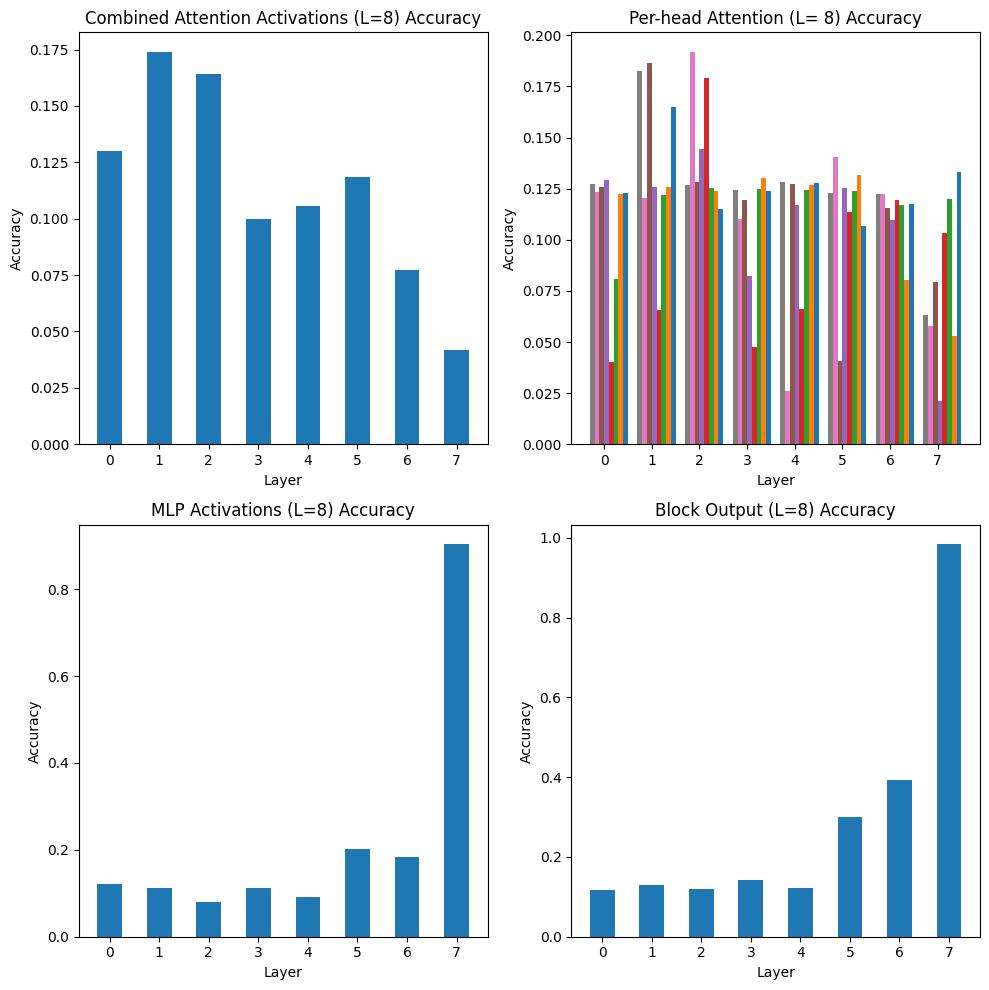

In [11]:
plot_all_accuracies(combined_attn_activations, mlp_activations, block_activations, attn_activations,
                        my_model, dataset_config, custom_config, y, ln_f=True
                       )

# Plot a models prediction by layer using one of the activations above

In [12]:
def plot_preds_per_layer(dataset_config, y, activations, my_model, custom_config):
    selected_idx = dataset_config['span_length']
    selected_y = y.reshape(-1)[-selected_idx:]
    
    all_preds = []
    soft_maxs = []
    for cur_block in activations:
        preds, pre_soft_vals = predict_outputs(my_model, dataset_config, custom_config, 
                                cur_block, y, 
                                is_hidden_state=True, return_preds=True, return_soft=True)
        selected_preds = preds[-selected_idx:].cpu().detach().numpy()
        selected_soft = pre_soft_vals[-selected_idx:]
        selected_soft = F.softmax(selected_soft, dim=1)
        selected_soft = np.array([selected_soft[idx][selected_preds[idx]].cpu().detach().numpy() for idx in range(len(selected_preds))])
        all_preds.append(np.expand_dims(selected_preds, 0))
        soft_maxs.append(np.expand_dims(selected_soft, 0))
    all_preds = np.concatenate(all_preds)
    soft_maxs = np.concatenate(soft_maxs)

    fig, ax = plt.subplots(2, 1, figsize=(15, 20))
    im = ax[0].imshow(soft_maxs)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    for i in range(all_preds.shape[0]):
        for j in range(all_preds.shape[1]):
            text = ax[0].text(j, i, all_preds[i, j],
                           ha="center", va="center", color="w")
    
    detached_y = np.expand_dims(selected_y.cpu().detach().numpy(), 0)
    black_background = np.ones_like(detached_y)
    ax[1].imshow(black_background)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    for i in range(detached_y.shape[1]):
        text = ax[1].text(i, 0, detached_y[0][i],
                       ha="center", va="center", color="w")
    
    fig.tight_layout()
    plt.colorbar(im,fraction=0.025, pad=0.04)

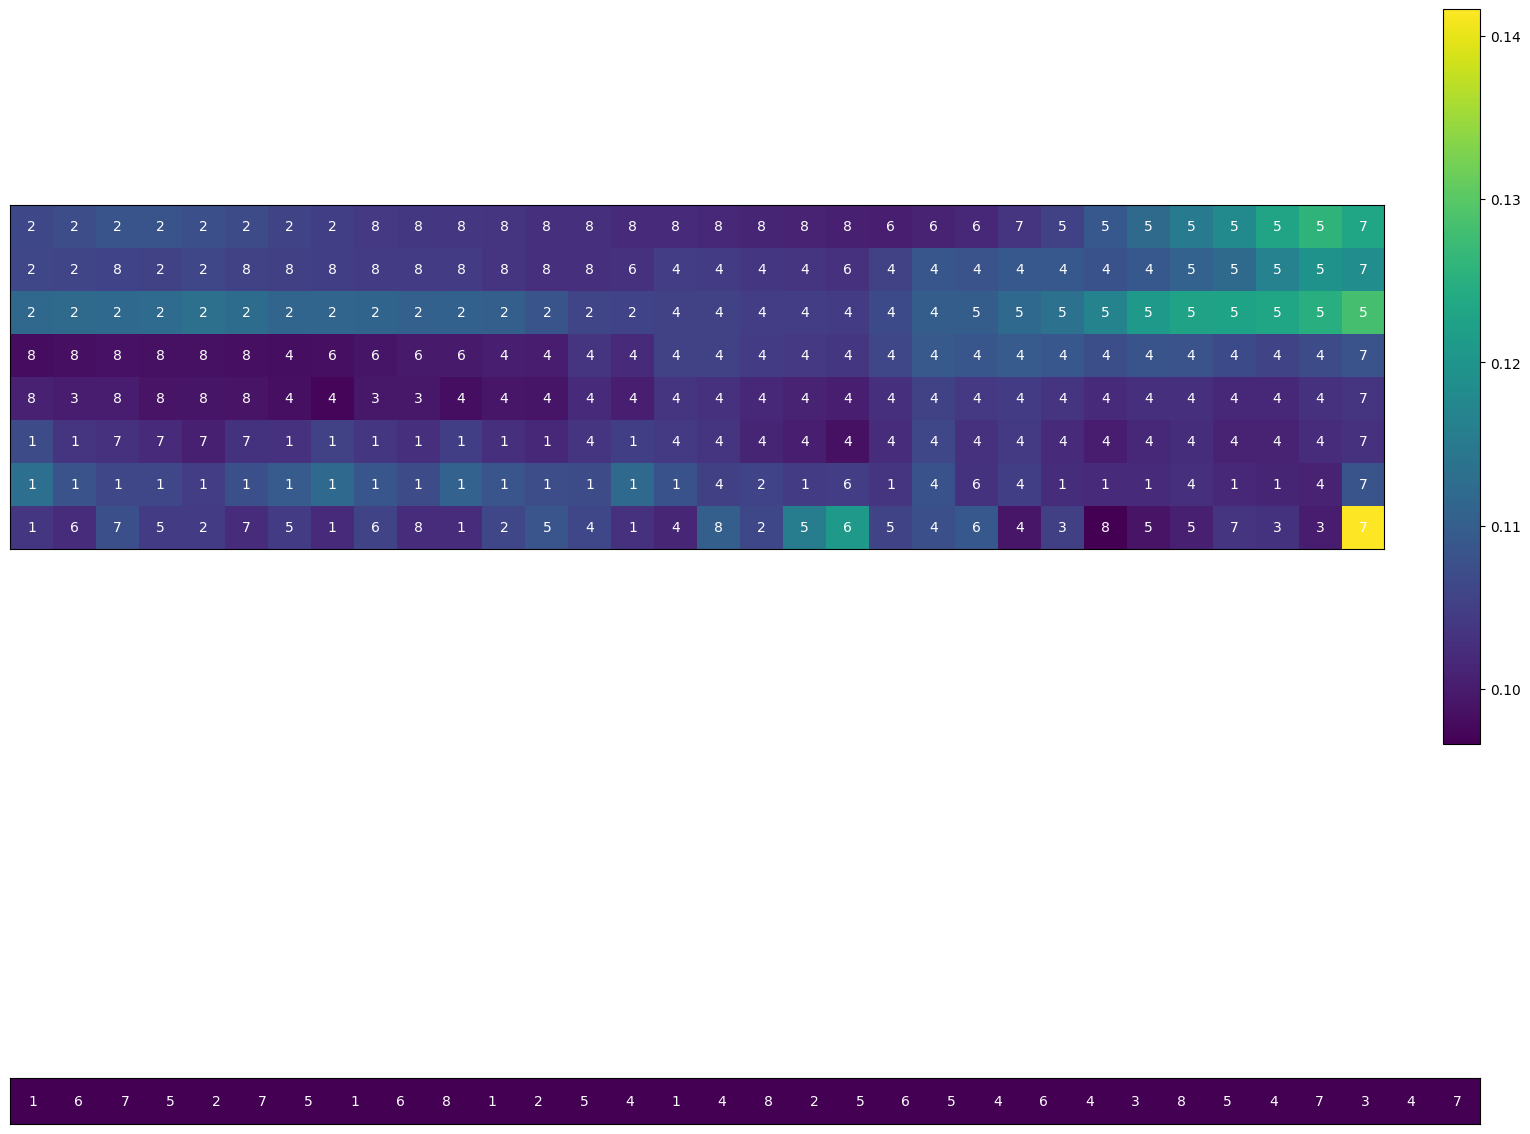

In [11]:
plot_preds_per_layer(dataset_config, y, block_activations, my_model, custom_config)

# Plot overrall model accuracy by the location within each span

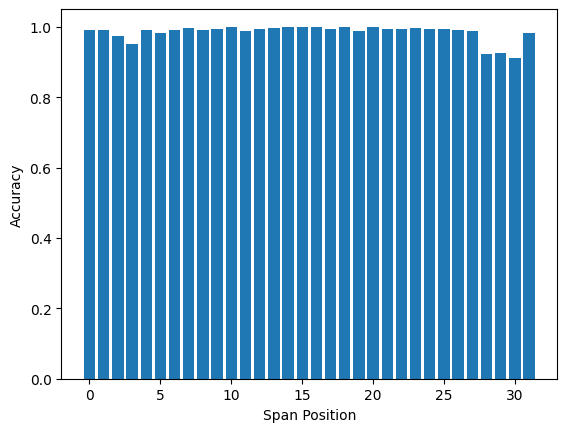

In [12]:
my_model.output_attentions = False
outputs = my_model(x)
correct_arr = predict_outputs(my_model, dataset_config, custom_config, outputs, y, is_hidden_state=False)
plot_accuracy_by_pos(dataset_config, y.reshape(-1), correct_arr)

# Plot Accuracy by position for several activations

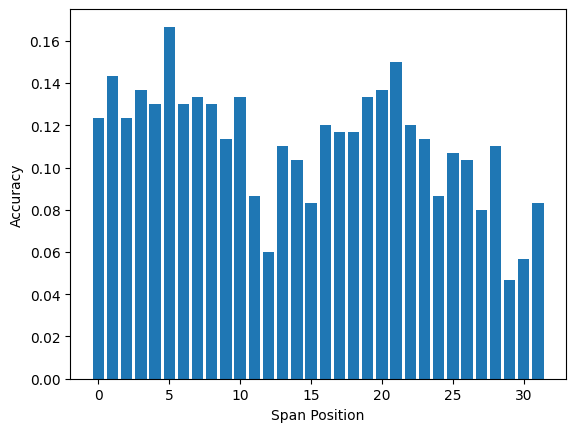

In [13]:
correct_arr = predict_outputs(my_model, dataset_config, custom_config, combined_attn_activations[0], y)
plot_accuracy_by_pos(dataset_config, y.reshape(-1), correct_arr)

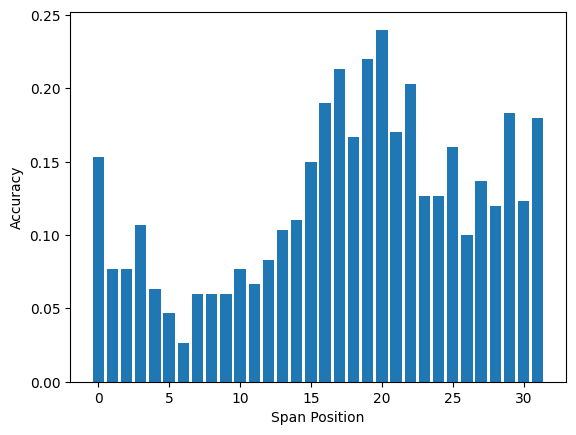

In [14]:
correct_arr = predict_outputs(my_model, dataset_config, custom_config, combined_attn_activations[1], y)
plot_accuracy_by_pos(dataset_config, y.reshape(-1), correct_arr)

# Plot Activations accuracy when exiting according to entropy threshold
### Here, we separately consider exiting all instances in a given layer/head when a corresponding entropy value is below some threshold (represented here along the x-axis). The accuracy when exiting uses the given activation and feeds that through the output head.
### The two methods for entropy are 
1. Calculate the entropy of the corresponding attention layer outputs for a given token.
2. Take the activation and use the decoder head to produce an output probabilities. Exit when the value is above some threshold.

In [1]:
def plot_soft_entropies(my_model, dataset_config, custom_config, activations, y, ax, title):
    
    preds, pre_softmax = predict_outputs(my_model, dataset_config, custom_config, activations, y, 
                                    is_hidden_state=True, return_preds=True, return_soft=True)
    soft_outs = F.softmax(pre_softmax, dim=1)
    entropies = entropy(soft_outs.cpu().detach(), axis=1)

    _ = ax.hist(entropies)
    ax.set_title(title)
    
def plot_all_soft_entropies(my_model, dataset_config, custom_config,
                            mlp_activations, block_activations, 
                            combined_attn_activations, attn_activations,
                            layer_idx=0):
    fig, ax = plt.subplots(2, 2, figsize=(10, 15))
    
    plot_soft_entropies(my_model, dataset_config, 
                        custom_config, mlp_activations[layer_idx], 
                        y, ax[0][0], "MLP Activations")
    plot_soft_entropies(my_model, dataset_config, 
                        custom_config, block_activations[layer_idx], 
                        y, ax[0][1], "Block Activations")
    plot_soft_entropies(my_model, dataset_config, 
                        custom_config, combined_attn_activations[layer_idx], 
                        y, ax[1][0], "Mean Attention Activations")
    plot_soft_entropies(my_model, dataset_config, 
                        custom_config, attn_activations[layer_idx, :, 0], 
                        y, ax[1][1], "Per-head Attention Activations")

# Plot of Exiting with Attention Entropy

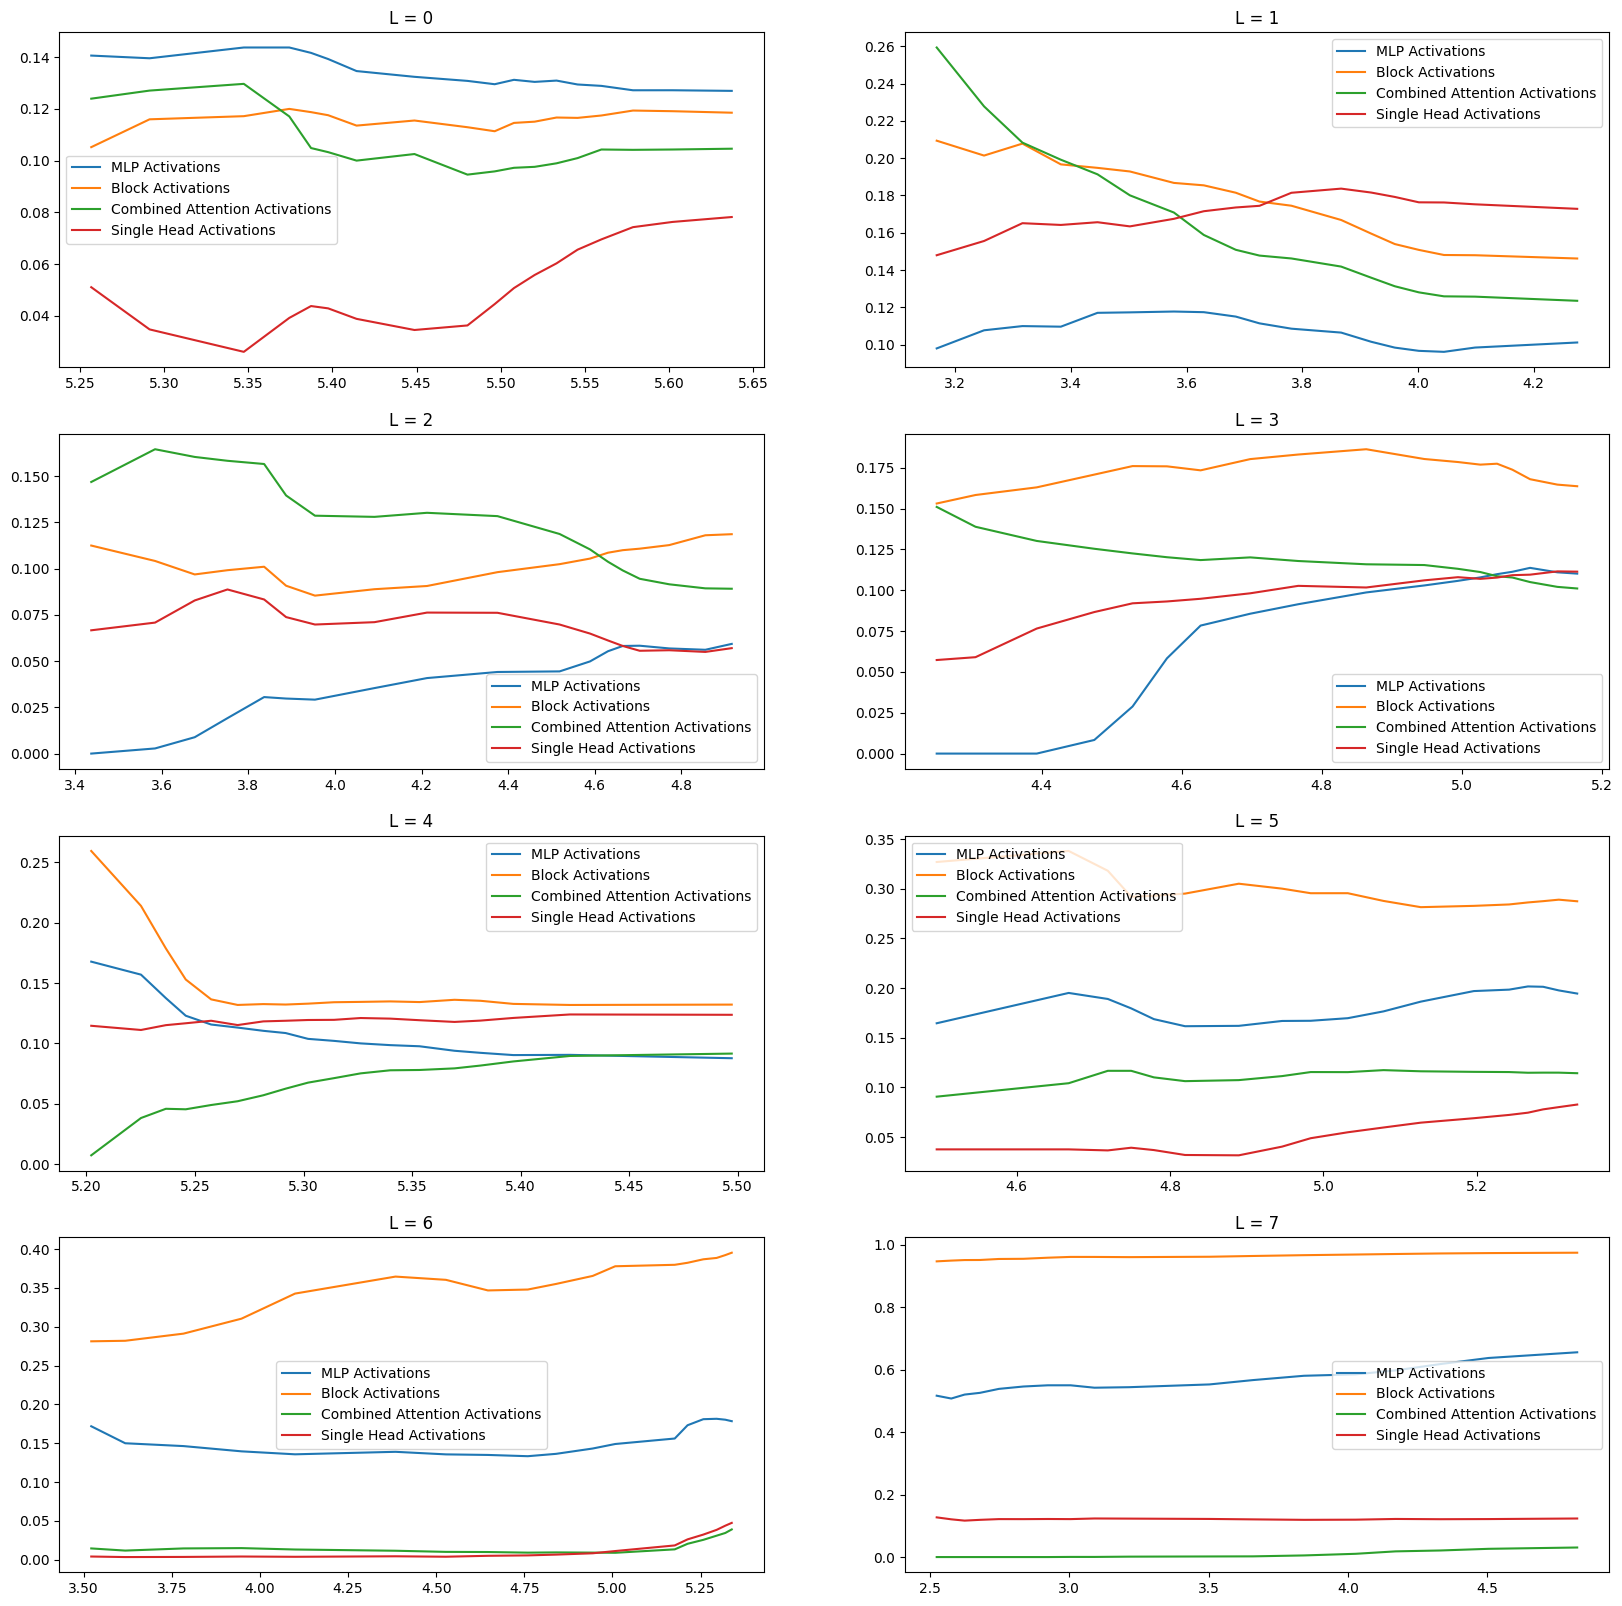

In [34]:
def plot_entropy_exit(attention, dataset_config, my_model ,custom_config, activations, ax, label, layer_idx = 0):
    
    mean_attention = torch.mean(attention[layer_idx], dim=1)
    attention_entropies = entropy(mean_attention.cpu().detach().numpy(), axis=2)
    selected_entropies = attention_entropies[:, -dataset_config['num_spans']*dataset_config['span_length']:].reshape(-1)
    
    entropy_bins = np.percentile(selected_entropies, np.arange(10, 100, 5))

    accuracies = []
    for tol in entropy_bins:
        mask = selected_entropies < tol
        
        bool_correct = predict_outputs(my_model, dataset_config, custom_config, activations[layer_idx], y, 
                                            mask=mask)
        accuracies.append((sum(bool_correct)/sum(mask)).cpu().detach().numpy())

    ax.plot(entropy_bins, accuracies, label=label)

cols = 2
rows = int(custom_config.num_hidden_layers/cols)
fig, ax = plt.subplots(rows, cols, figsize=(20, 20))
for layer_idx in range(custom_config.num_hidden_layers):
    row_idx = layer_idx // cols
    col_idx = layer_idx % cols
    plot_entropy_exit(attention, dataset_config, my_model,
                      custom_config, mlp_activations, ax[row_idx][col_idx], "MLP Activations", layer_idx = layer_idx)
    plot_entropy_exit(attention, dataset_config, my_model,
                      custom_config, block_activations, ax[row_idx][col_idx], "Block Activations", layer_idx = layer_idx)
    plot_entropy_exit(attention, dataset_config, my_model,
                      custom_config, combined_attn_activations, ax[row_idx][col_idx], "Combined Attention Activations", layer_idx = layer_idx)
    plot_entropy_exit(attention, dataset_config, my_model,
                      custom_config, attn_activations[:, :, 0], ax[row_idx][col_idx], "Single Head Activations", layer_idx = layer_idx)
    ax[row_idx][col_idx].set_title("L = " + str(layer_idx))
    ax[row_idx][col_idx].legend()

# Plot of exiting with Softmax entropy

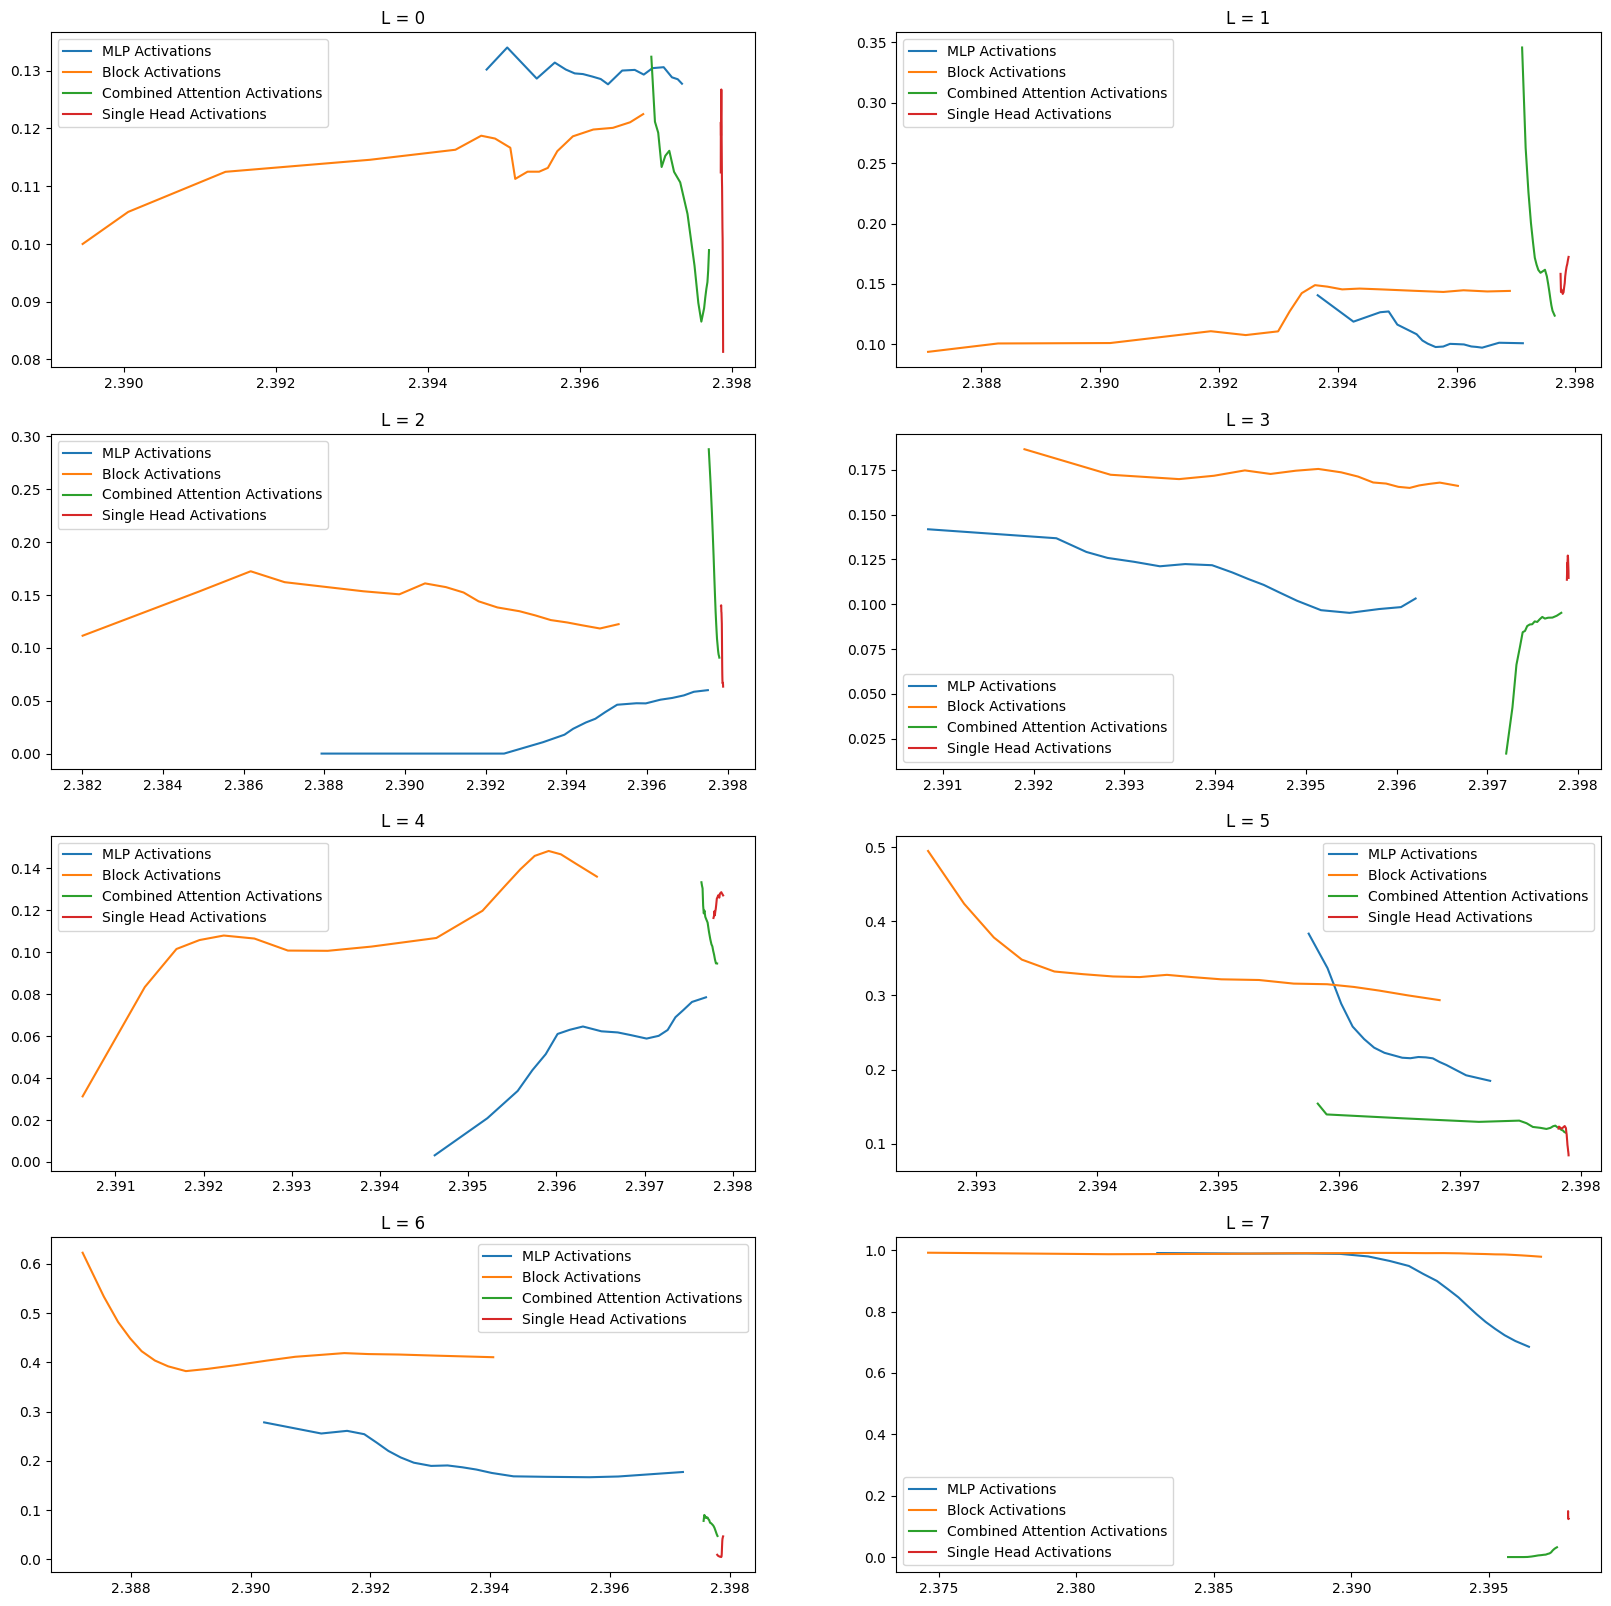

In [35]:
def plot_entropy_exit_s(attention, dataset_config, my_model ,custom_config, activations, ax, label, layer_idx = 0):
    
    preds, pre_softmax = predict_outputs(my_model, dataset_config, custom_config, activations[layer_idx], y, 
                                    is_hidden_state=True, return_preds=True, return_soft=True)
    soft_outs = F.softmax(pre_softmax, dim=1)
    selected_entropies = entropy(soft_outs.cpu().detach(), axis=1)
    
    entropy_bins = np.percentile(selected_entropies, np.arange(10, 100, 5))

    accuracies = []
    for tol in entropy_bins:
        mask = selected_entropies < tol
        
        bool_correct = predict_outputs(my_model, dataset_config, custom_config, activations[layer_idx], y, 
                                            mask=mask)
        accuracies.append((sum(bool_correct)/sum(mask)).cpu().detach().numpy())

    ax.plot(entropy_bins, accuracies, label=label)

cols = 2
rows = int(custom_config.num_hidden_layers/cols)
fig, ax = plt.subplots(rows, cols, figsize=(20, 20))
for layer_idx in range(custom_config.num_hidden_layers):
    row_idx = layer_idx // cols
    col_idx = layer_idx % cols
    plot_entropy_exit_s(attention, dataset_config, my_model,
                      custom_config, mlp_activations, ax[row_idx][col_idx], "MLP Activations", layer_idx = layer_idx)
    plot_entropy_exit_s(attention, dataset_config, my_model,
                      custom_config, block_activations, ax[row_idx][col_idx], "Block Activations", layer_idx = layer_idx)
    plot_entropy_exit_s(attention, dataset_config, my_model,
                      custom_config, combined_attn_activations, ax[row_idx][col_idx], "Combined Attention Activations", layer_idx = layer_idx)
    plot_entropy_exit_s(attention, dataset_config, my_model,
                      custom_config, attn_activations[:, :, 0], ax[row_idx][col_idx], "Single Head Activations", layer_idx = layer_idx)
    ax[row_idx][col_idx].set_title("L = " + str(layer_idx))
    ax[row_idx][col_idx].legend()